In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import Video
from time import time as timer

# --- Constant parameters ---
ms = 1.0     # Mass
es = 1.0     # Electric charge
rho2l = 0.1  # Ratio of Larmor radius to scale length
a0 = 2.0     # Minor radius
r0 = 6.0     # Major radius
b0 = 3.0     # Magnetic field strength
q0 = 1.0     # Safety factor
s0 = 3.0     # Magnetic shear

# --- Time step control ---
dt = 0.01
nt = 38000
nskip = 2
nsave = nt // nskip
print(nsave)

# --- Model function of magnetic field ---
def func_b(x, y, z):
    mr = np.sqrt(x**2 + y**2)
    sr = np.sqrt((mr - r0)**2 + z**2)
    q = q0 * (1.0 + s0 * sr / a0)
    bx = b0 * r0 * y / mr**2 - b0 * x * z / (q * mr**2)
    by = - b0 * r0 * x / mr**2 - b0 * y * z / (q * mr**2)
    bz = b0 * (mr - r0) / (q * mr)
    return np.array([bx, by, bz])

# --- Equation of motion ---
def time_derivative(xv):
    x, y, z, vx, vy, vz = xv
    b = func_b(x, y, z)
    dxdt = np.array([vx, vy, vz])
    dvdt = (es / ms) * np.cross(np.array([vx, vy, vz]), b) / rho2l
    return np.concatenate((dxdt, dvdt))

# --- Time integration by dt using 4th-order Runge-Kutta method ---
def time_integration_rk4(xv):
    k1 = time_derivative(xv)
    k2 = time_derivative(xv + 0.5 * dt * k1)
    k3 = time_derivative(xv + 0.5 * dt * k2)
    k4 = time_derivative(xv + dt * k3)
    return xv + (dt / 6.0) * (k1 + 2.0*k2 + 2.0*k3 + k4)

# --- Time integration
def compute_trajectory(t_init, xv_init):
    t = t_init
    xv = xv_init
    time = [t_init]
    trajectory = [xv_init]
    for _ in range(nsave):
        for _ in range(nskip):
            xv = time_integration_rk4(xv)
            t += dt
        trajectory.append(xv)
        time.append(t)

    trajectory = np.array(trajectory)
    time = np.array(time)
    return time, trajectory

# --- Set initial values ---
t_init = 0.0
# xv_init = np.array([7.8, 0.0, 0.0, 0.0, -1.5, -0.5])  # [x, y, z, vx, vy, vz] for passing particle
xv_init = np.array([7.8, 0.0, 0.0, 0.0, -0.5, -1.0])  # [x, y, z, vx, vy, vz] for trapped particle

print("Computation of a charged particle tajectory.")
elt0 = timer()
time, trajectory = compute_trajectory(t_init, xv_init)
elt1 = timer()
print("Elapsed time for computation [sec]:", elt1 - elt0)
print(time.shape, trajectory.shape)

19000
Computation of a charged particle tajectory.
Elapsed time for computation [sec]: 9.453125238418579
(19001,) (19001, 6)


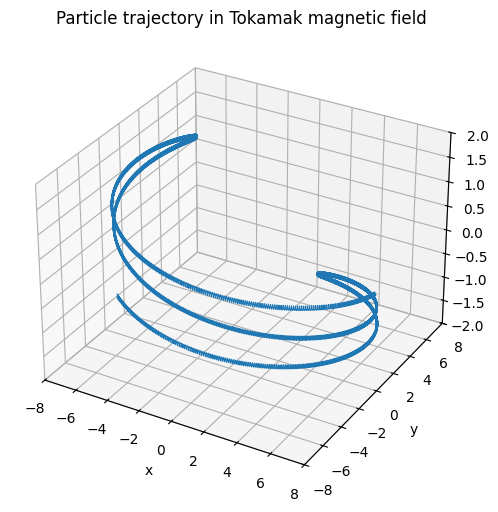

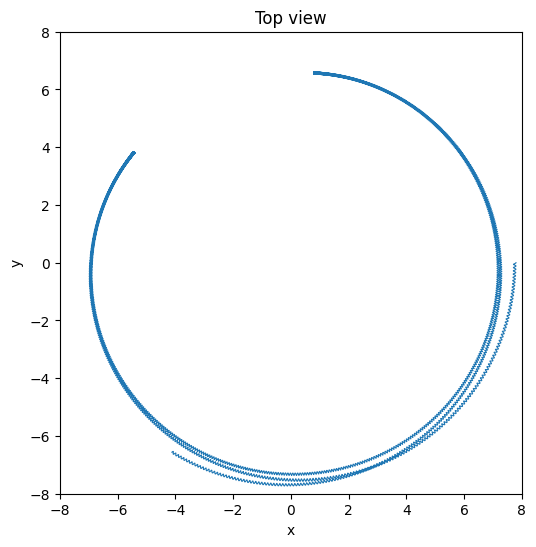

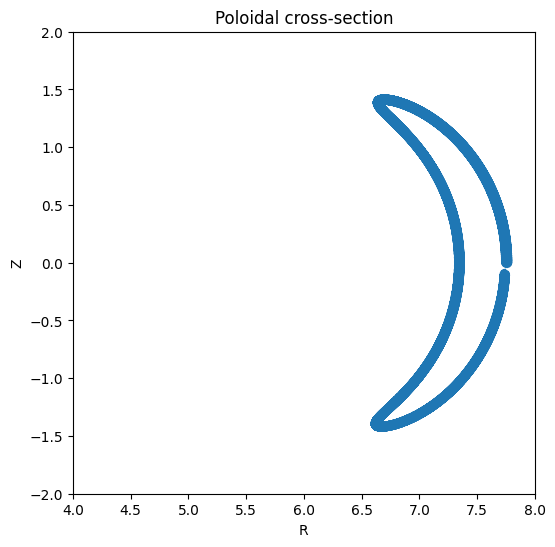

In [22]:
x, y, z, vx, vy, vz = trajectory.T
mr = np.sqrt(x**2 + y**2)

# --- 3D visualization ---
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
ax.plot(x, y, z, lw=0.8)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim(-r0-a0,r0+a0)
ax.set_ylim(-r0-a0,r0+a0)
ax.set_zlim(-a0,a0)
ax.set_title("Particle trajectory in Tokamak magnetic field")
plt.show()

# --- Top view ---
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.plot(x, y, lw=0.8)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(-r0-a0,r0+a0)
ax.set_ylim(-r0-a0,r0+a0)
ax.set_aspect("equal")
ax.set_title("Top view")
plt.show()

# --- Poloidal cross-section ---
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.plot(mr, z, lw=0.8)
ax.set_xlabel("R")
ax.set_ylabel("Z")
ax.set_xlim(r0-a0,r0+a0)
ax.set_ylim(-a0,a0)
ax.set_aspect("equal")
ax.set_title("Poloidal cross-section")
plt.show()

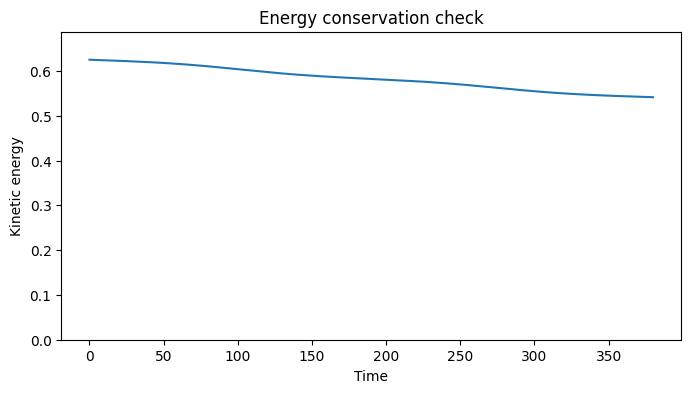

In [23]:
# --- Check energy conservation ---
energy = 0.5*(vx**2 + vy**2 + vz**2)
plt.figure(figsize=(8,4))
plt.ylim(0, 1.1 * np.max(energy))
plt.plot(time, energy)
plt.xlabel("Time")
plt.ylabel("Kinetic energy")
plt.title("Energy conservation check")
plt.show()

In [24]:
elt0 = timer()
# --- Animation ---
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim(-r0-a0,r0+a0)
ax.set_ylim(-r0-a0,r0+a0)
ax.set_zlim(-a0,a0)

# --- Draw particle trajectory ---
#   Update only particle and orbit, while reusing fig, ax
orbit, = ax.plot([], [], [], lw=0.5, c='tab:blue')
particle, = ax.plot([], [], [], 'o', c='tab:blue')
def update_trajectorys(i):
    orbit.set_data(x[:i+1],y[:i+1])
    orbit.set_3d_properties(z[:i+1])
    particle.set_data(x[i:i+1],y[i:i+1])
    particle.set_3d_properties(z[i:i+1])
    return [orbit, particle]

ani = FuncAnimation(fig, update_trajectorys,
                    frames=range(0,len(time),100), interval=50, blit=True)

ani.save("trajectory.mp4", writer="ffmpeg", fps=30)
plt.close()
elt1 = timer()
print("Elapsed time for animation [sec]:", elt1 - elt0)

Video("trajectory.mp4", embed=True)

Elapsed time for animation [sec]: 24.771778345108032
